In [1]:
import os, glob
import sys
import copy 
import pydicom
import random
import re
import scipy
import scipy.misc
import numpy as np
import cv2
import imageio
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
import tensorflow as tf
from tensorflow import keras
from scipy.ndimage import rotate
from skimage import exposure
plt.set_cmap('gray')
%matplotlib inline
## Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed


IMG_DTYPE = np.float
SEG_DTYPE = np.uint8


In [2]:
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [3]:
masks_path = os.path.join('train','masks')
training_path = os.path.join('train','patients')

In [4]:
def histeq(im,nbr_bins=256):

   #get image histogram
   imhist,bins = np.histogram(im.flatten(),nbr_bins)
   cdf = imhist.cumsum() #cumulative distribution function
   cdf = 255 * cdf / cdf[-1] #normalize

   #use linear interpolation of cdf to find new pixel values
   im2 = np.interp(im.flatten(),bins[:-1],cdf)

   return im2.reshape(im.shape), cdf

In [5]:

def stat(array):
    print('min',np.min(array),'max',np.max(array),'median',np.median(array),'avg',np.mean(array))
def imshow(*args,**kwargs):
    """ Handy function to show multiple plots in on row, possibly with different cmaps and titles
    Usage: 
    imshow(img1, title="myPlot")
    imshow(img1,img2, title=['title1','title2'])
    imshow(img1,img2, cmap='hot')
    imshow(img1,img2,cmap=['gray','Blues']) """
    cmap = kwargs.get('cmap', 'gray')
    title= kwargs.get('title','')
    if len(args)==0:
        raise ValueError("No images given to imshow")
    elif len(args)==1:
        plt.title(title)
        plt.imshow(args[0], interpolation='none')
    else:
        n=len(args)
        if type(cmap)==str:
            cmap = [cmap]*n
        if type(title)==str:
            title= [title]*n
        plt.figure(figsize=(n*5,10))
        for i in range(n):
            plt.subplot(1,n,i+1)
            plt.title(title[i])
            plt.imshow(args[i], cmap[i])
    plt.show()
    
def to_scale(img, shape=None):

    height, width = shape
    if img.dtype == SEG_DTYPE:
        return scipy.misc.imresize(img,(height,width),interp="nearest").astype(SEG_DTYPE)
    elif img.dtype == IMG_DTYPE:
        max_ = np.max(img)
        factor = 255.0/max_ if max_ != 0 else 1
#         return (scipy.misc.imresize(img,(height,width),interp="nearest")/factor).astype(IMG_DTYPE)
        return np.array(Image.fromarray(img).resize([height, width])/factor).astype(IMG_DTYPE)
    else:
        raise TypeError('Error. To scale the image array, its type must be np.uint8 or np.float64. (' + str(img.dtype) + ')')


def normalize_image(img):
    """ Normalize image values to [0,1] """
    min_, max_ = float(np.min(img)), float(np.max(img))
    return (img - min_) / (max_ - min_)


def adjust_gamma(image, gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
 
    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)

In [6]:
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=8, image_size=128):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()
        
    def __load__(self, id_name):

        tumor_volume = None
        
        image_path = os.path.join(self.path,"patients", id_name)
        mask_path = os.path.join(self.path,"masks")
        all_masks = os.listdir(mask_path)
        dicom_image = pydicom.dcmread(image_path)
        
        image = step1_preprocess_img_slice(dicom_image.pixel_array)
       
        liver_mask_id = id_name.split('_')
        liver_mask = pydicom.dcmread(os.path.join(mask_path, liver_mask_id[0]+'_liver', id_name)).pixel_array
        
        image = np.multiply(image,np.clip(liver_mask,0,1))
        
#         image[liver_mask == 0] = 0
#         image[liver_mask == 1] = 1
        image = np.array(Image.fromarray(image).resize([image_size, image_size])).astype(IMG_DTYPE)
        mask = cv2.imread(os.path.join(masks_path,'merged_livertumors', id_name+'.jpg'))
        
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        retval, mask = cv2.threshold(mask, 100, 255, cv2.THRESH_BINARY)
        mask = np.array(Image.fromarray(mask).resize([image_size, image_size])).astype(IMG_DTYPE)
        mask = mask // 255
        
        mask = mask[:, :, np.newaxis]
        
        return image, mask
    
    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
#         print(files_batch)
        image = []
        mask  = []
    
        for id_name in files_batch:

            _img, _mask = self.__load__(id_name)
            _img = np.stack((_img,)*3, axis=-1)
            image.append(_img)
            mask.append(_mask)
        
        image = np.array(image)
        mask  = np.array(mask)

        return image, mask
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))
    


In [17]:
image_size =  256
train_path = "train"
batch_size = 8
epochs = 10
## Training Ids
images = []
for file in os.listdir(os.path.join(train_path, "patients")):

    images.append(file)
print(len(images))


## Validation Data Size
val_data_size = 200

valid_ids = images[:val_data_size]
train_ids = images[val_data_size:]

# partition = len(train_ids_all)//5
# offset = 2
print(train_ids[23])
# train_ids = train_ids_all[:partition*offset] #subset
# print(len(train_ids))


23271
1.6_image_2791_augrot


In [8]:
temp_epochs = train_ids[:240]
count = 0
for tumor in temp_epochs:
    mask = cv2.imread(os.path.join('train','masks','merged_livertumors', tumor+'.jpg'))
    if 1 in mask:
        count += 1
print(count)

213


In [9]:
def step1_preprocess_img_slice(img_slc):
    """
    Preprocesses the image 3d volumes by performing the following :
    1- Set pixels with hounsfield value great than 1200, to zero.
    2- Clip all hounsfield values to the range [-100, 400]
    """    
    img_slc[img_slc>1200] = 0
    img_slc   = np.clip(img_slc, -100, 400)
    img_slc = normalize_image(img_slc)

    
    img_slc = img_slc * 255
    img_slc = img_slc.astype('uint8')
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img_slc = clahe.apply(img_slc)
# #     img_slc = exposure.equalize_hist(img_slc)
# #     img_slc = cv2.blur(img_slc,(5,5))
# #     img_slc = adjust_gamma(img_slc, gamma=2)
# #     img_slc = cv2.Laplacian(img_slc,cv2.CV_64F)
# #     img_slc = cv2.Sobel(img_slc,cv2.CV_64F,0,1,ksize=-1)
    img_slc = normalize_image(img_slc)
#     kernel = np.ones((5,5),np.uint8)
#     img_slc = cv2.morphologyEx(img_slc, cv2.MORPH_OPEN, kernel)
    return img_slc


In [10]:
gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=image_size)
x, y = gen.__getitem__(4)
print(x.shape,y.shape)

(8, 256, 256, 3) (8, 256, 256, 1)


In [11]:
# z = y[y > 0]
# print(len(z),z)

0


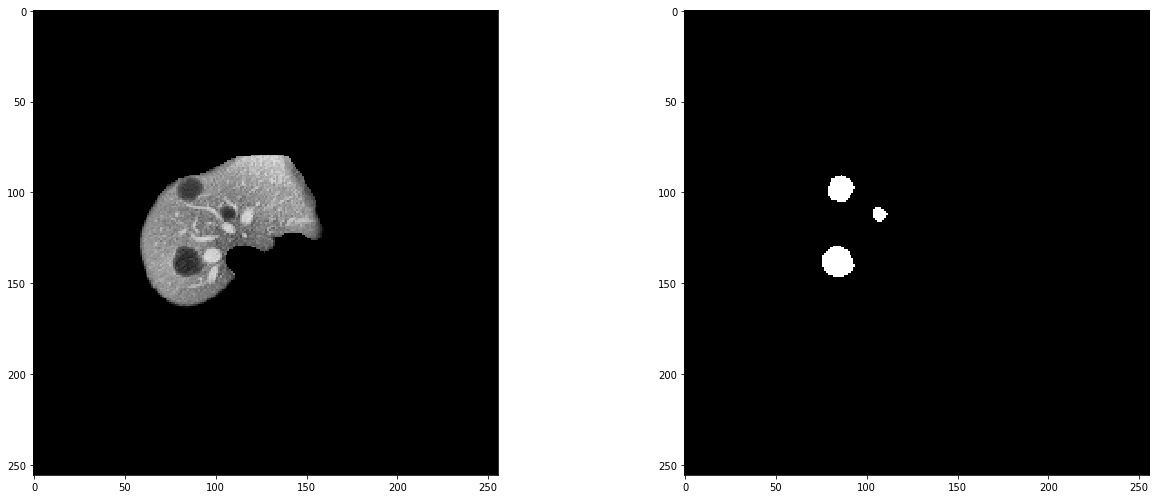

In [12]:
r = random.randint(0, len(x)-1)
r = 0
fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
print(r)
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[r], (image_size, image_size)), cmap="gray")

In [15]:
# def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
#     c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
#     c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
#     p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
#     return c, p

# def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
#     us = keras.layers.UpSampling2D((2, 2))(x)
#     concat = keras.layers.Concatenate()([us, skip])
#     c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
#     c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
#     return c

# def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
#     c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
#     c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
#     return c

In [16]:
# def UNet():
#     f = [16, 32, 64, 128, 256]
#     inputs = keras.layers.Input((image_size, image_size, 3))
    
#     p0 = inputs
#     c1, p1 = down_block(p0, f[0]) #128 -> 64
#     c2, p2 = down_block(p1, f[1]) #64 -> 32
#     c3, p3 = down_block(p2, f[2]) #32 -> 16
#     c4, p4 = down_block(p3, f[3]) #16->8
    
#     bn = bottleneck(p4, f[4])
    
#     u1 = up_block(bn, c4, f[3]) #8 -> 16
#     u2 = up_block(u1, c3, f[2]) #16 -> 32
#     u3 = up_block(u2, c2, f[1]) #32 -> 64
#     u4 = up_block(u3, c1, f[0]) #64 -> 128
    
#     outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
#     model = keras.models.Model(inputs, outputs)
#     return model

In [17]:
# model = UNet()
# model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"], sample_weight_mode='temporal')
# # model.summary()

In [13]:
def bn_act(x, act=True):
    x = keras.layers.BatchNormalization()(x)
    if act == True:
        x = keras.layers.Activation("relu")(x)
    return x

def conv_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = bn_act(x)
    conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)
    return conv

def stem(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    conv = conv_block(conv, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    
    shortcut = keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    
    output = keras.layers.Add()([conv, shortcut])
    return output

def residual_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    res = conv_block(x, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    res = conv_block(res, filters, kernel_size=kernel_size, padding=padding, strides=1)
    
    shortcut = keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    
    output = keras.layers.Add()([shortcut, res])
    return output

def upsample_concat_block(x, xskip):
    u = keras.layers.UpSampling2D((2, 2))(x)
    c = keras.layers.Concatenate()([u, xskip])
    return c

In [14]:
def ResUNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    ## Encoder
    e0 = inputs
    e1 = stem(e0, f[0])
    e2 = residual_block(e1, f[1], strides=2)
    e3 = residual_block(e2, f[2], strides=2)
    e4 = residual_block(e3, f[3], strides=2)
    e5 = residual_block(e4, f[4], strides=2)
    
    ## Bridge
    b0 = conv_block(e5, f[4], strides=1)
    b1 = conv_block(b0, f[4], strides=1)
    
    ## Decoder
    u1 = upsample_concat_block(b1, e4)
    d1 = residual_block(u1, f[4])
    
    u2 = upsample_concat_block(d1, e3)
    d2 = residual_block(u2, f[3])
    
    u3 = upsample_concat_block(d2, e2)
    d3 = residual_block(u3, f[2])
    
    u4 = upsample_concat_block(d3, e1)
    d4 = residual_block(u4, f[1])
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(d4)
    model = keras.models.Model(inputs, outputs)
    return model

In [15]:
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = tf.layers.flatten(y_true)
    y_pred_f = tf.layers.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [16]:
model = ResUNet()
adam = keras.optimizers.Adam()
model.compile(optimizer=adam, loss=dice_coef_loss, metrics=["acc", dice_coef])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.flatten instead.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 16) 0           batch_norm

In [18]:
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)
# test_gen  = DataGenTest(train_ids, train_path, image_size=image_size, batch_size=batch_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size

model.fit(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, 
                    epochs=epochs)

Epoch 1/10
2884/2884 [==============================] - 1336s 463ms/step - loss: 0.3379 - acc: 0.9935 - dice_coef: 0.6621 - val_loss: 0.3424 - val_acc: 0.9947 - val_dice_coef: 0.6576
Epoch 2/10
2884/2884 [==============================] - 1297s 450ms/step - loss: 0.2094 - acc: 0.9968 - dice_coef: 0.7906 - val_loss: 0.2487 - val_acc: 0.9957 - val_dice_coef: 0.7513
Epoch 3/10
2884/2884 [==============================] - 1293s 448ms/step - loss: 0.1764 - acc: 0.9973 - dice_coef: 0.8236 - val_loss: 0.1481 - val_acc: 0.9974 - val_dice_coef: 0.8519
Epoch 4/10
2884/2884 [==============================] - 1293s 448ms/step - loss: 0.1600 - acc: 0.9975 - dice_coef: 0.8400 - val_loss: 0.3196 - val_acc: 0.9946 - val_dice_coef: 0.6804
Epoch 5/10
2884/2884 [==============================] - 1291s 448ms/step - loss: 0.1478 - acc: 0.9977 - dice_coef: 0.8522 - val_loss: 0.1386 - val_acc: 0.9975 - val_dice_coef: 0.8614
Epoch 6/10
2884/2884 [==============================] - 1294s 449ms/step - loss: 0.14

In [23]:
# test_gen  = DataGenTest(valid_ids, train_path, image_size=image_size, batch_size=batch_size)

In [19]:
model.save('tumor_model_final_tenep.h5')  # creates a HDF5 file 'my_model.h5'
model.save_weights("tumor_weights_final_tenep.h5")
# model = keras.models.load_model('tumor_model_final.h5',compile=False)
# model.summary()

# del model

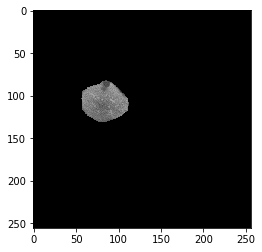

In [20]:
x, y = valid_gen.__getitem__(2)
result = model.predict(x)

# result = result > 0.5

imshow(x[1])


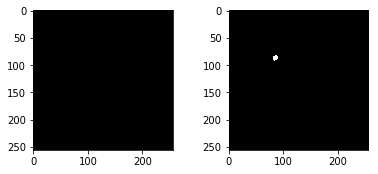

In [21]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[1]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[1]*255, (image_size, image_size)), cmap="gray")

In [32]:
print(result.shape)
true_cnt = 0
false_cnt = 0
for i in range(0, len(y[1])):
    for j in range(0, len(y[1][i])):
        if y[1][i][j][0]:
            true_cnt += 1
            print(y[1][i][j][0])
        else:
            false_cnt += 1
print(true_cnt)
print(false_cnt)

(8, 256, 256, 1)
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0

/home/amir/anaconda3/envs/tensorflow/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


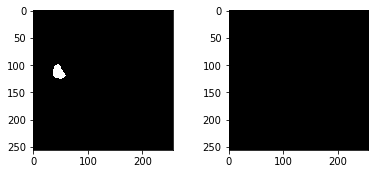

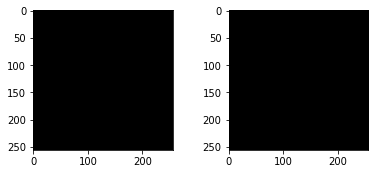

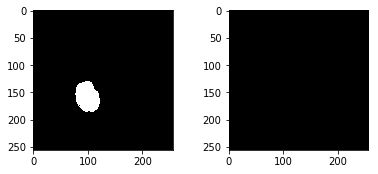

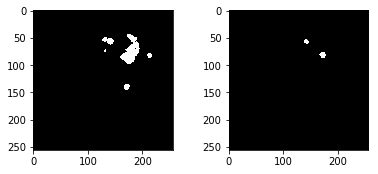

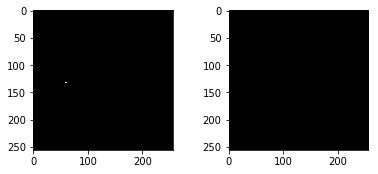

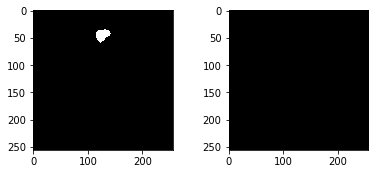

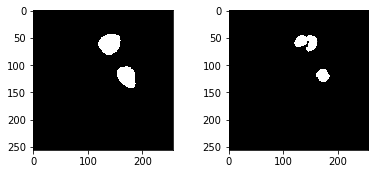

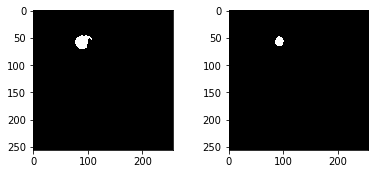

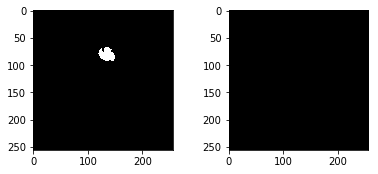

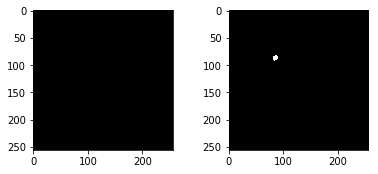

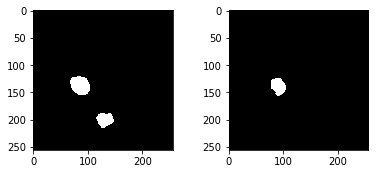

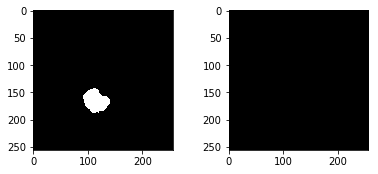

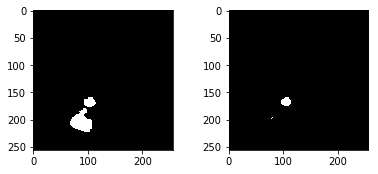

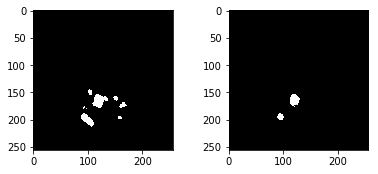

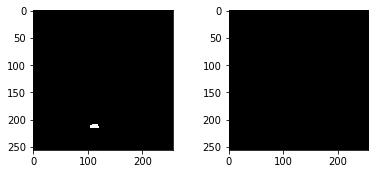

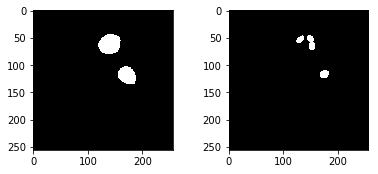

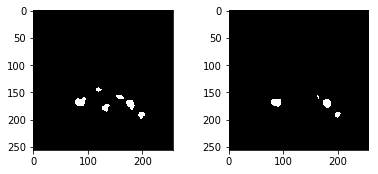

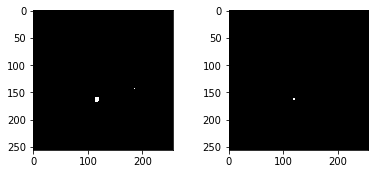

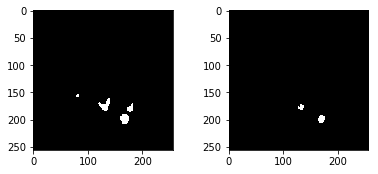

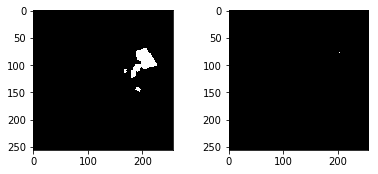

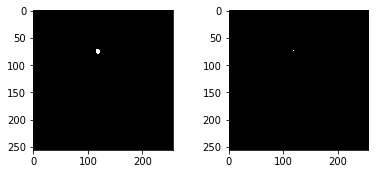

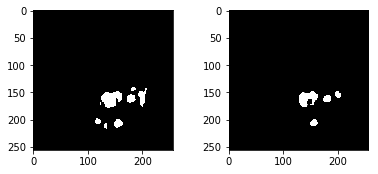

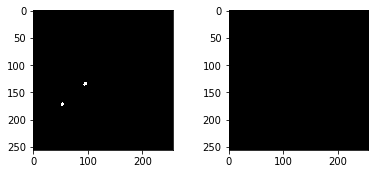

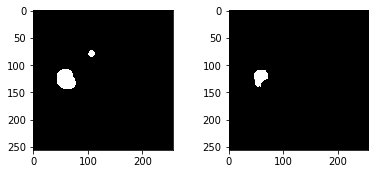

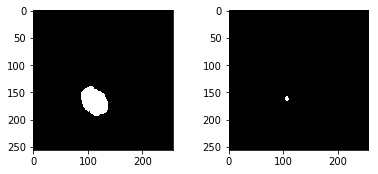

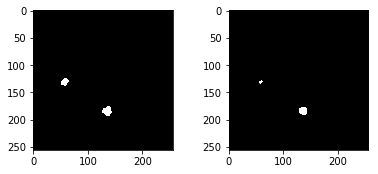

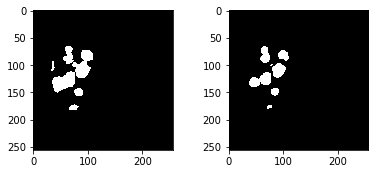

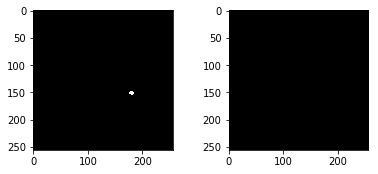

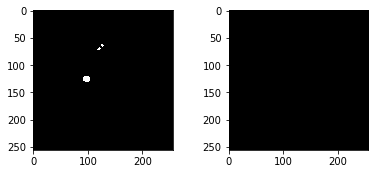

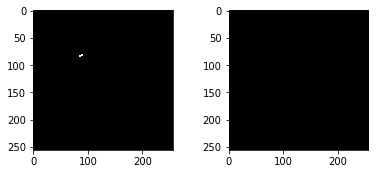

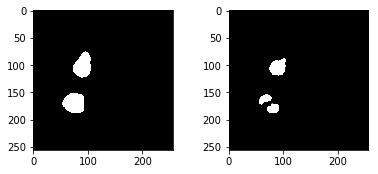

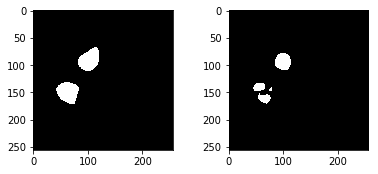

In [22]:
for i in range(1, 5, 1):
    ## Dataset for prediction
    x, y = valid_gen.__getitem__(i)
    result = model.predict(x)
#     result = result > 0.4
    
    for i in range(len(result)):
        fig = plt.figure()
        fig.subplots_adjust(hspace=0.4, wspace=0.4)

        ax = fig.add_subplot(1, 2, 1)
#         ax.imshow(np.reshape(y[i]*255, (image_size, image_size)), cmap="gray")
        ax.imshow(x[i])
        ax = fig.add_subplot(1, 2, 2)
        ax.imshow(np.reshape(result[i]*255, (image_size, image_size)), cmap="gray")